In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="1"


from keras.layers import Dense, Input, Dropout
from keras.models import Model

import omnifold8a as of

import tensorflow as tf


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.26.4
  tensorflow version:  2.13.1





## Set model and resolution parameters

In [3]:
ndim = 1

##-------------

train_mu = [ 0.0 ]



train_rho = [ [0.0] ]






train_sig = [ 1.0 ]


##-------------


true_mu = [ 0.2 ]






true_rho  = [ [0.0] ]



true_sig = [ 0.9 ]



#--- nominal
resolution = [ 0.5  ]

#--- poor
#resolution = [ 1.0  ]






train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
#-- about 10 seconds
#ngen_train = 10000
#ngen_true =   1000              

                
#-- about 62 seconds
#ngen_train = 100000
#ngen_true =    1000       


#-- about 37  (29 in of8a)  seconds
ngen_train = 100000
ngen_true =   10000

#-- about 47  (38 in of8a)  seconds
#ngen_train = 1000000
#ngen_true =   100000

#-- about 1   (56 seconds) minute
#ngen_train = 2000000
#ngen_true =   200000

#-- about 1:50  (1:48 in of8a)
#ngen_train = 4000000
#ngen_true =   400000

#-- about 5 min
#ngen_train = 10000000
#ngen_true =   1000000







of_niter = 5

#learning_rate_setval = 0.0005
#epochs_setval = 40

#learning_rate_setval = 0.0001
#epochs_setval = 10

#learning_rate_setval = 0.00002
#epochs_setval = 40

#learning_rate_setval = 0.0005
#epochs_setval = 10

#learning_rate_setval = 0.0010
#epochs_setval = 10

#learning_rate_setval = 0.0008
#epochs_setval = 10


learning_rate_setval = 0.0005
epochs_setval = 20




#dropout_setval = 0.02

dropout_setval = 0.10




do_bootstrap = False

n_boot_samples = 1000





batch_size_setval = int( ngen_true )



output_dir = 'bootstrap-toy-study8a-1d-1b'

save_step2_model = True





 Train covariance:
   0,  0 : diagonal    1.0000



 True covariance:
   0,  0 : diagonal    0.8100


In [4]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()

In [5]:
print("\n\n")
print("Train covariance determinant:  %f" % np.linalg.det( train_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




Train covariance determinant:  1.000000
True covariance determinant:   0.810000





In [6]:
train_cov_inv = np.linalg.inv( train_cov )

In [7]:
train_cov_inv_test = np.matmul( train_cov, train_cov_inv )

In [8]:
print("\n\n")
print(" Train covariance")
print( train_cov )
print("\n Train covariance inverse")
print( train_cov_inv )
print("\n Train covariance inverse test")
print(train_cov_inv_test)
print("\n\n")




 Train covariance
[[1.]]

 Train covariance inverse
[[1.]]

 Train covariance inverse test
[[1.]]





In [9]:
true_cov_inv = np.linalg.inv( true_cov )

In [10]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [11]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[0.81]]

 True covariance inverse
[[1.2345679]]

 True covariance inverse test
[[1.]]





## Generate samples, save events and config

In [12]:


train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

train_det_pts = np.random.normal( train_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )


true_pts10x = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true*40)
true_det_pts10x = np.random.normal( true_pts10x, resolution )
true_pts10x_weights = np.ones( ngen_true*40 )
true_pts10x_weights = (1./40.) * true_pts10x_weights


In [13]:
with open( '%s/train-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, train_pts)
    np.save(f, train_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [14]:
with open( '%s/config-pars.npy' % output_dir , 'wb' ) as f :
    np.save( f, train_mu )
    np.save( f, train_rho )
    np.save( f, train_sig )
    np.save( f, true_mu )
    np.save( f, true_rho )
    np.save( f, true_sig )
    np.save( f, resolution )
    np.save( f, train_cov )
    np.save( f, true_cov )

In [15]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_train %d\n' % ngen_train )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )
config_file.write('learning_rate_setval  %f\n' % learning_rate_setval )
config_file.write('epochs_setval  %d\n' % epochs_setval )
config_file.write('batch_size_setval  %d\n' % batch_size_setval )


config_file.write('\n\n')
config_file.write('train_mu : %s\n' % str(train_mu))
config_file.write('train_rho : %s\n' % str(train_rho))
config_file.write('train_sig : %s\n' % str(train_sig))
config_file.write('train_cov : %s\n' % str(train_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : bootstrap-toy-study8a-1d-1b/config.txt

2024-07-08 17:14:35.514473

ngen_train 100000
ngen_true  10000
of_niter   5
ndim       1
learning_rate_setval  0.000500
epochs_setval  20
batch_size_setval  10000


train_mu : [0.0]
train_rho : [[0.0]]
train_sig : [1.0]
train_cov : [[1.]]


true_mu : [0.2]
true_rho : [[0.0]]
true_sig : [0.9]
true_cov : [[0.81]]


resolution : [0.5]





## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

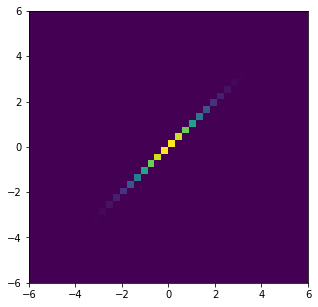

In [16]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
            
        thisax.hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

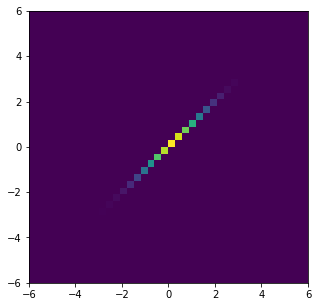

In [17]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
        thisax.hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

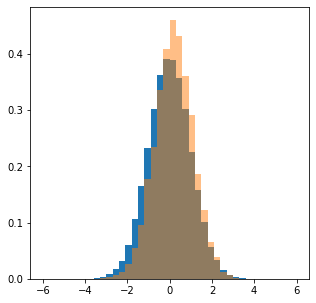

In [18]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        if ndim > 1 :
            thisax = ax[i]
        else :
            thisax = ax
        thisax.hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        thisax.hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

### Calculate true weights analytically and compare with unfolding output weights.

In [19]:
train_pts_minus_train_mu = train_pts - train_mu
print(train_pts_minus_train_mu)

[[ 0.03172564]
 [-0.84935352]
 [ 1.13444767]
 ...
 [ 0.38233233]
 [-0.26370761]
 [ 0.12668488]]


In [20]:
train_pts_minus_true_mu = train_pts - true_mu
print(train_pts_minus_true_mu)

[[-0.16827436]
 [-1.04935352]
 [ 0.93444767]
 ...
 [ 0.18233233]
 [-0.46370761]
 [-0.07331512]]


In [21]:
true_cov_inv_times_v = np.tensordot( true_cov_inv, train_pts_minus_true_mu.T, axes=(1,0) )

In [22]:
v_times_true_cov_inv_times_v =  np.sum( train_pts_minus_true_mu.T * true_cov_inv_times_v, axis=0)

In [23]:
train_cov_inv_times_v = np.tensordot( train_cov_inv, train_pts_minus_train_mu.T, axes=(1,0) )

In [24]:
v_times_train_cov_inv_times_v =  np.sum( train_pts_minus_train_mu.T * train_cov_inv_times_v, axis=0)

In [25]:
exp_v_times_train_cov_inv_times_v = np.exp( -0.5 * v_times_train_cov_inv_times_v )
exp_v_times_true_cov_inv_times_v  = np.exp( -0.5 * v_times_true_cov_inv_times_v  )

In [26]:
true_cov_det = np.linalg.det( true_cov )
train_cov_det = np.linalg.det( train_cov )

In [27]:
norm2_true = np.power( 3.14159265, ndim) * true_cov_det
print("\n norm2_true : %f\n" % norm2_true )


 norm2_true : 2.544690



In [28]:
norm2_train = np.power( 3.14159265, ndim) * train_cov_det
print("\n norm2_train : %f\n" % norm2_train )


 norm2_train : 3.141593



In [29]:
pdf_train = exp_v_times_train_cov_inv_times_v / np.sqrt(norm2_train)
print(pdf_train)

[0.56390572 0.393346   0.29645771 ... 0.52442443 0.54490937 0.55968034]


In [30]:
pdf_true = exp_v_times_true_cov_inv_times_v / np.sqrt(norm2_true)
print(pdf_true)

[0.61601523 0.31767634 0.36567434 ... 0.61414386 0.54895668 0.6248008 ]


In [31]:
pdf_ratio = pdf_true / pdf_train

In [32]:
sample_sf = (1.*len(true_pts))/(1.*len(train_pts))
print('\n sample_sf = %f' % sample_sf )


 sample_sf = 0.100000


In [33]:
calc_weight = pdf_ratio

In [34]:
calc_weight_scaled = sample_sf * pdf_ratio

## Set up NN model for OmniFold

In [35]:

import tensorflow.keras.backend as K


def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))

    return K.mean(t_loss)

In [36]:


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(20, activation='relu')(inputs)
#hidden_layer_2 = Dense(20, activation='relu')(hidden_layer_1)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_2)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_2)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
#hidden_layer_4 = Dense(50, activation='relu')(hidden_layer_3)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_4)

#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_1)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(20, activation='relu')(inputs)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_1)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(200, activation='relu')(inputs)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_1)

#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(150, activation='relu')(inputs)
#hidden_layer_2 = Dense(150, activation='relu')(hidden_layer_1)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_2)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#hidden_layer_2 = Dense(10, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(5, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(5, activation='relu')(inputs)
#hidden_layer_2 = Dense(10, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(30, activation='relu')(inputs)
#hidden_layer_2 = Dense(40, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(20, activation='relu')(inputs)
#hidden_layer_2 = Dense(20, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(20, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)



inputs = Input((ndim, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
drop1 = Dropout(dropout_setval)(hidden_layer_1)
hidden_layer_2 = Dense(50, activation='relu')(drop1)
drop2 = Dropout(dropout_setval)(hidden_layer_2)
hidden_layer_3 = Dense(50, activation='relu')(drop2)
drop3 = Dropout(dropout_setval)(hidden_layer_3)
outputs = Dense(1, activation='sigmoid')(drop3)








model_step1 = Model(inputs=inputs, outputs=outputs)
model_step2 = Model(inputs=inputs, outputs=outputs)

opt_step1 = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )
opt_step2 = tf.keras.optimizers.Adam( learning_rate=(0.04*learning_rate_setval) )  # owen: use lower learning rate in step 2

model_step1.compile(loss=weighted_binary_crossentropy,
                      optimizer=opt_step1,
                      metrics=['accuracy'])

model_step2.compile(loss=weighted_binary_crossentropy,
                      optimizer=opt_step2,
                      metrics=['accuracy'])


## Package the training data for OmniFold

In [37]:
train_both = np.stack([train_pts, train_det_pts], axis=1)

## Run OmniFold

In [38]:
%%time


#verbose = True
verbose = False






of_return_dict = of.omnifold8a( 
    train_both, true_det_pts, of_niter, model_step1, model_step2, verbose, 
    batch_size_setval, epochs_setval,
    save_step2_model, output_dir
)

of_weights = of_return_dict["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = of_return_dict["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = of_return_dict["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)


 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1b/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08361995 0.8679992  1.20905447 ... 1.12424004 1.04160631 1.08908582]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1b/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07566358 0.82136345 1.22252203 ... 1.11934242 1.02969079 1.08016435]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1b/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08344388 0.81781015 1.24156389 ... 1.12922322 1.03614418 1.08836401]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1b/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08630147 0.81179849 1.25830603 ... 1.13905798 1.03947188 1.09155232]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1b/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/of-step2-iter04-model/assets


CPU times: user 22.9 s, sys: 3.73 s, total: 26.7 s
Wall time: 19 s


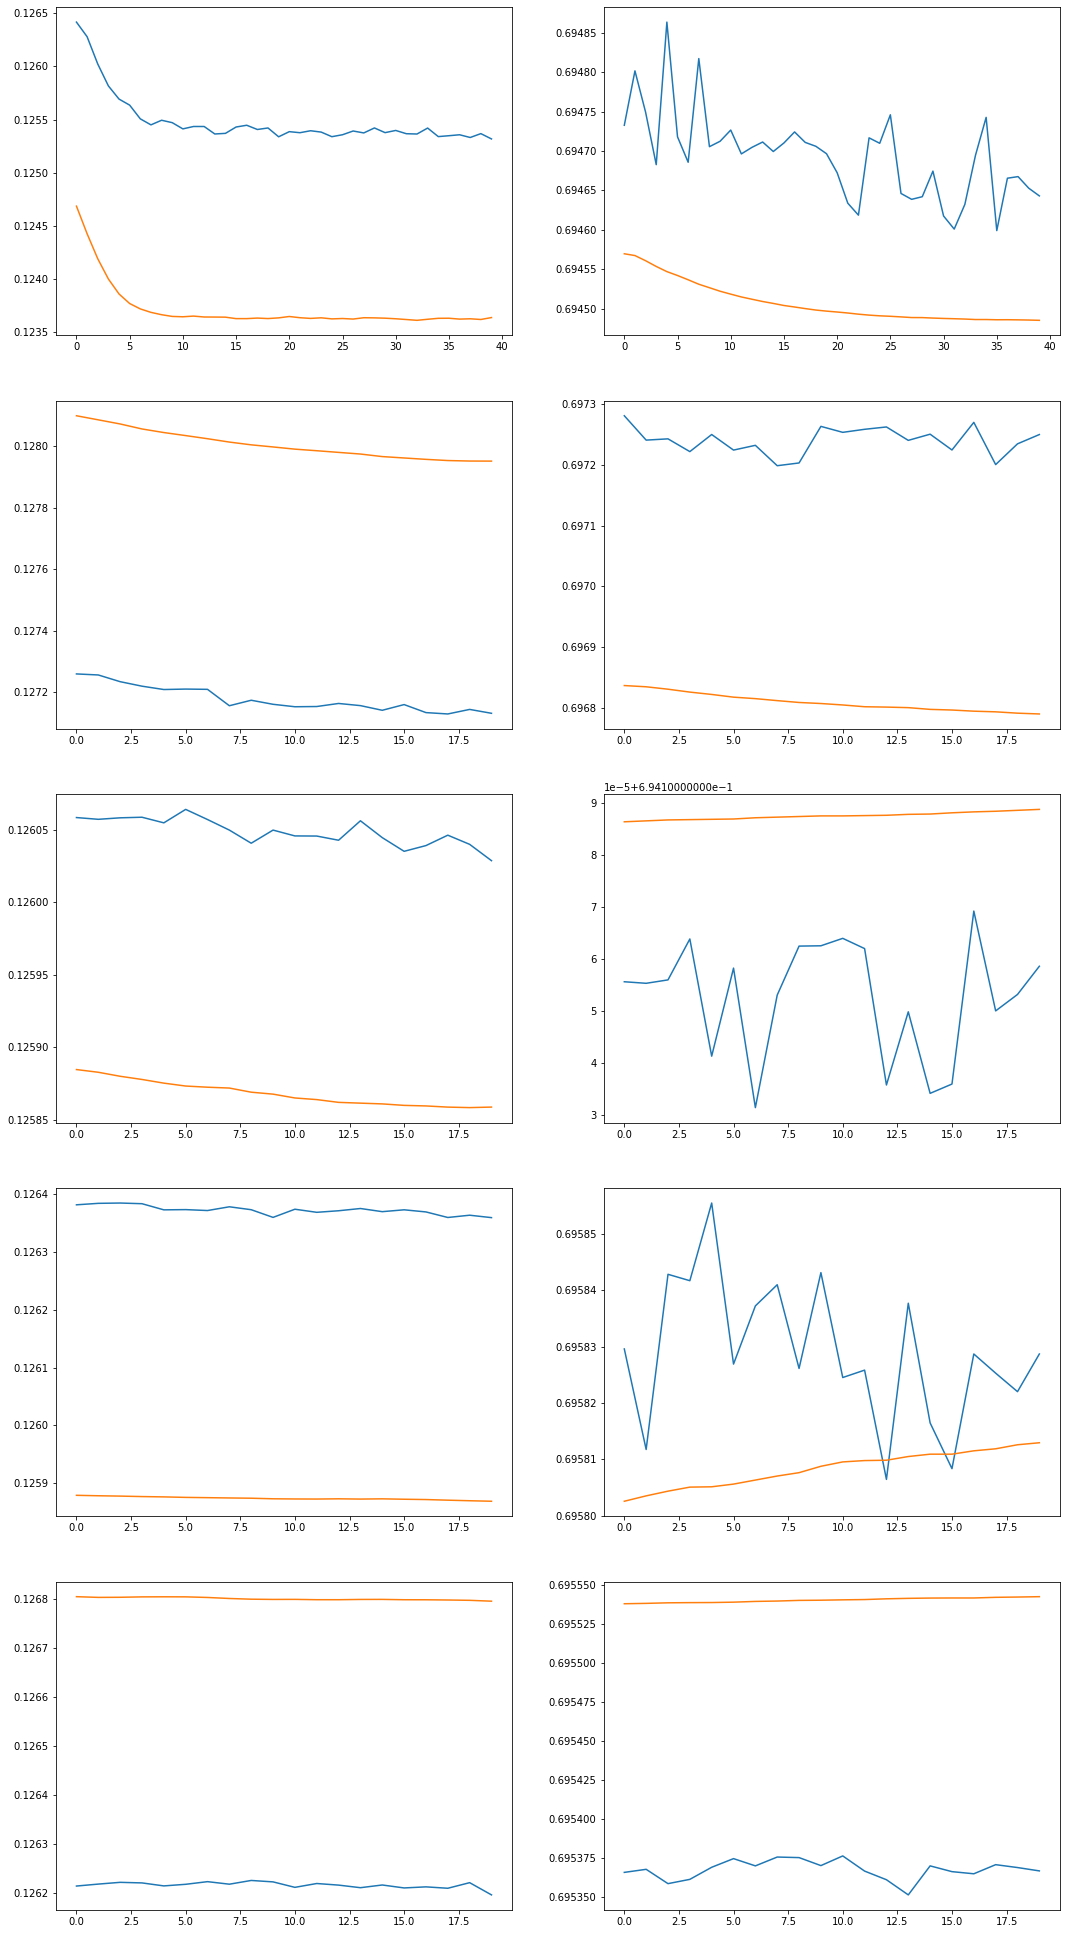

In [39]:
fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

for ofi in range(0,of_niter) :
    
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['loss']  )
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['val_loss']  )

    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['loss']  )
    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['val_loss']  )
    



<function matplotlib.pyplot.show(close=None, block=None)>

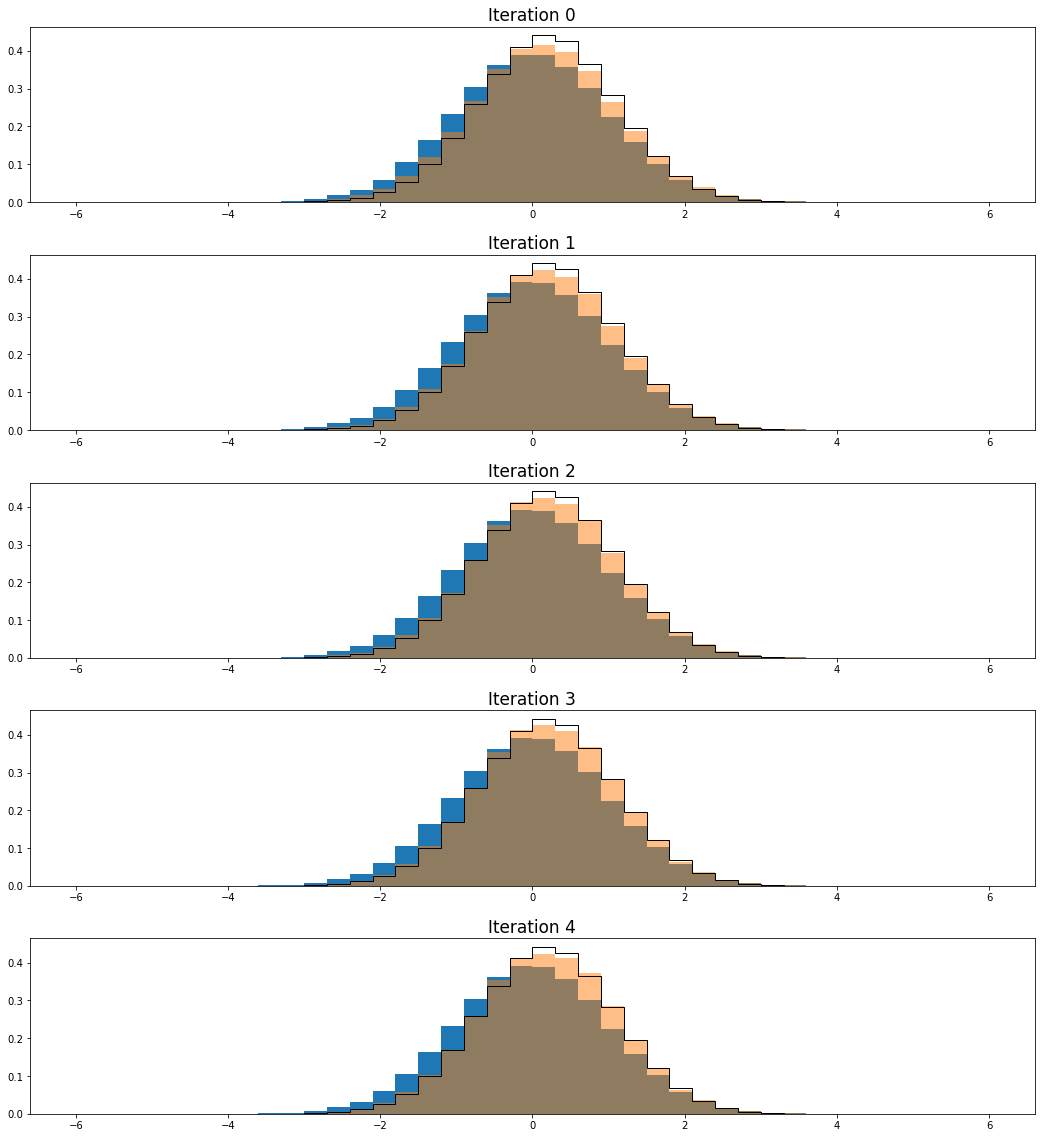

In [40]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
                
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
 
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
        
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [41]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

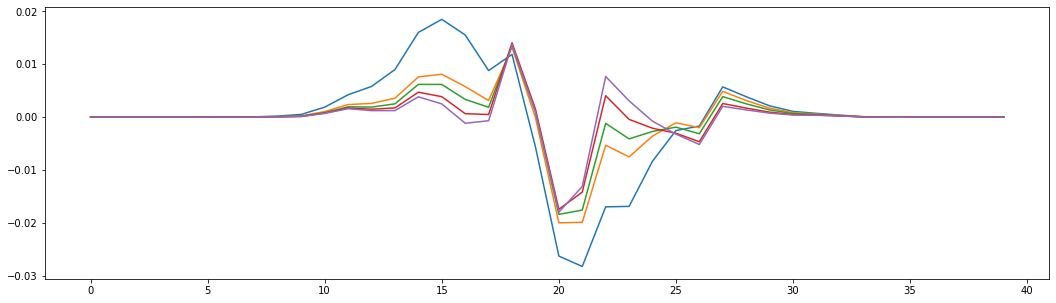

In [42]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

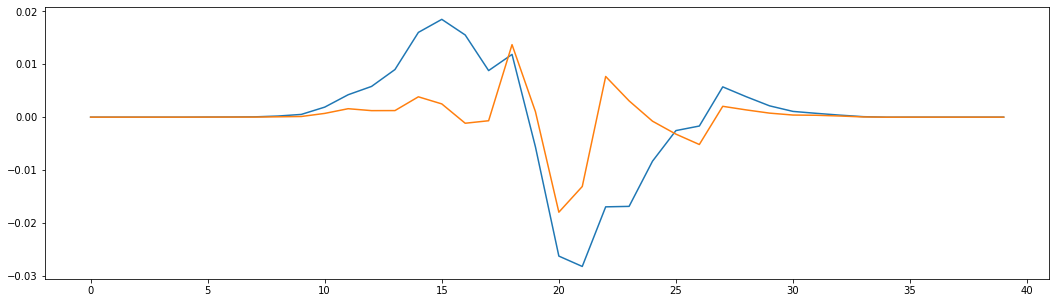

In [43]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])
    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

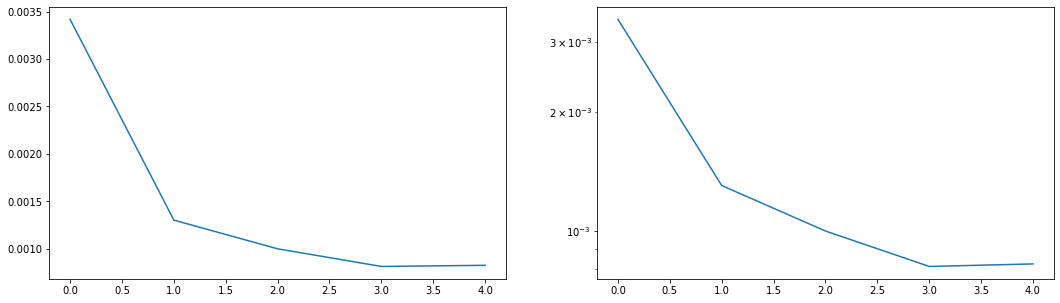

In [44]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

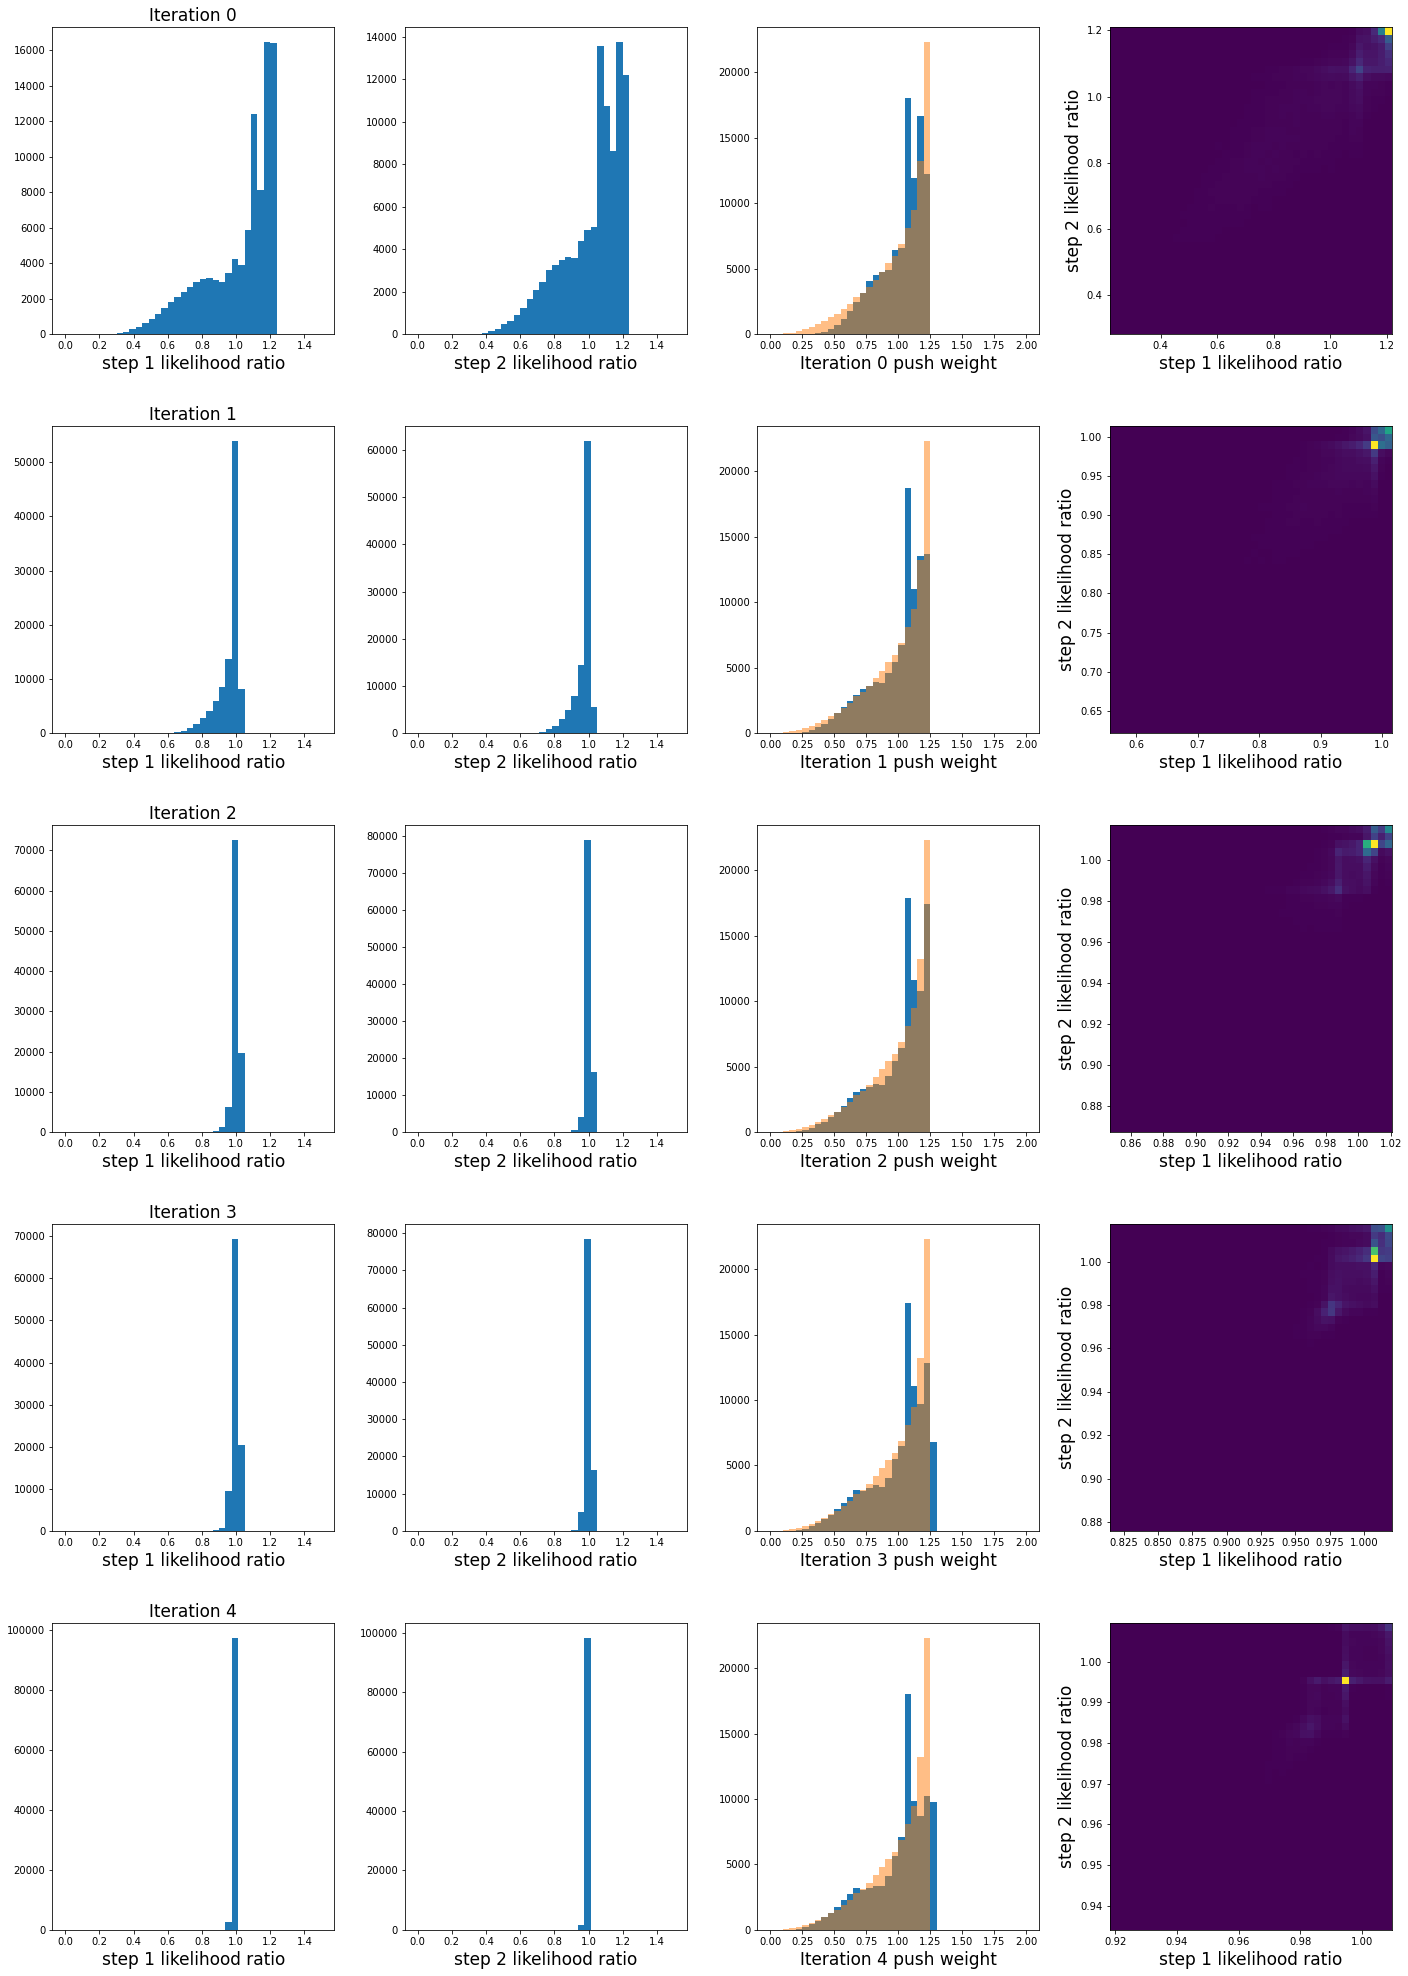

In [45]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,2.0] )
    ax[ofi][2].hist( calc_weight, bins=hbins, range=[0.,2.0], alpha=0.5 )
    
    
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'Iteration %d push weight' % ofi, fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

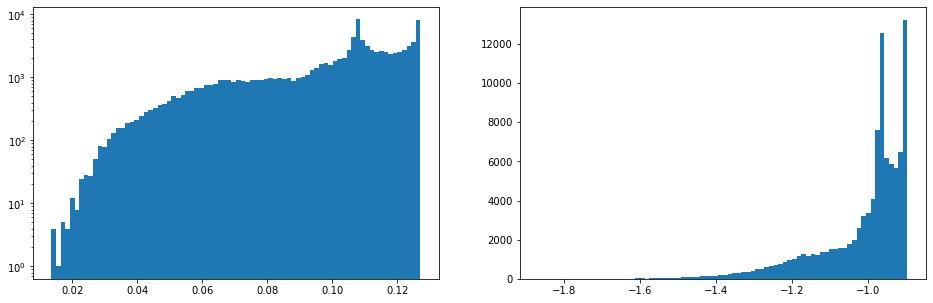

In [46]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

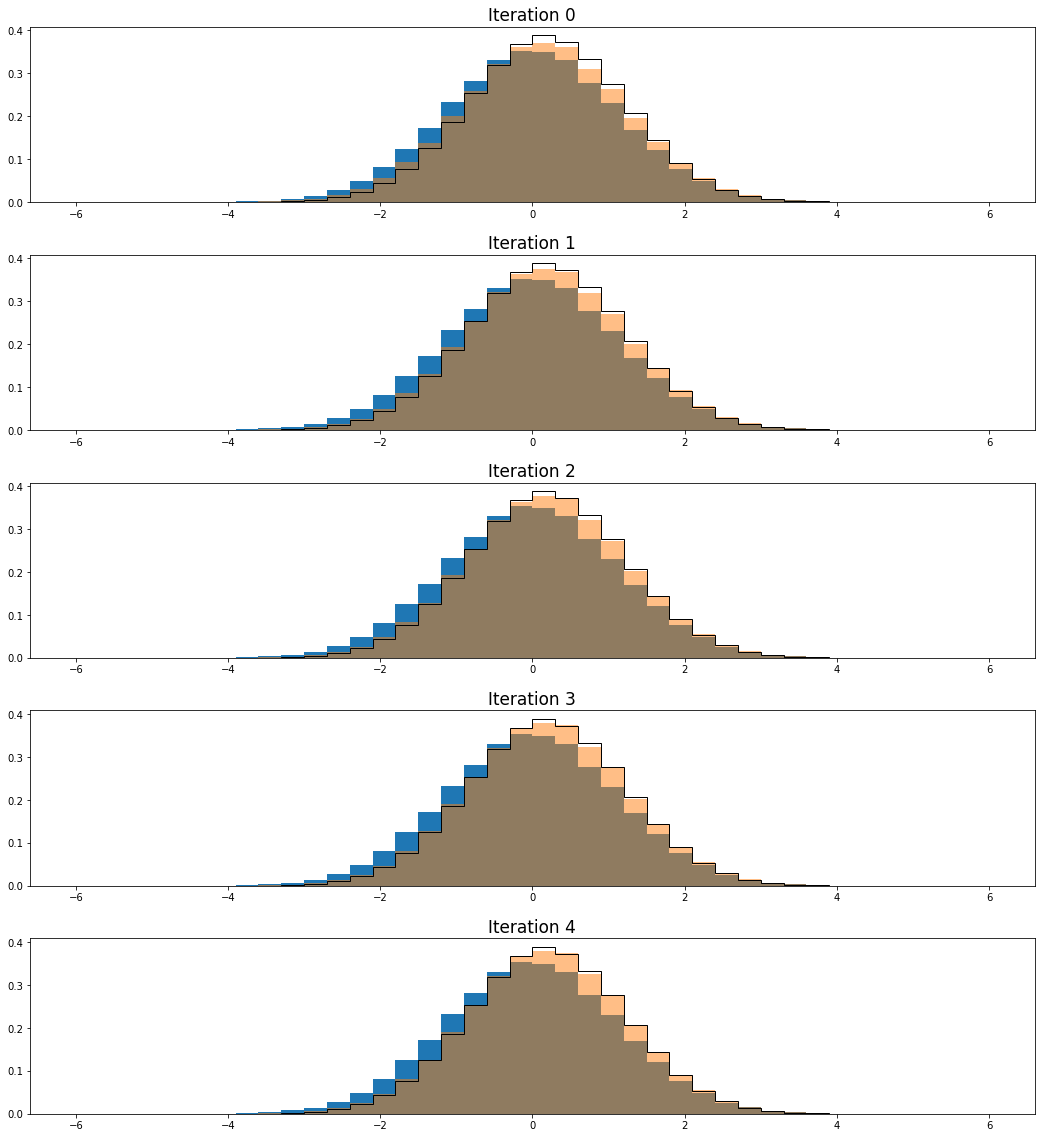

In [47]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
    
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [48]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

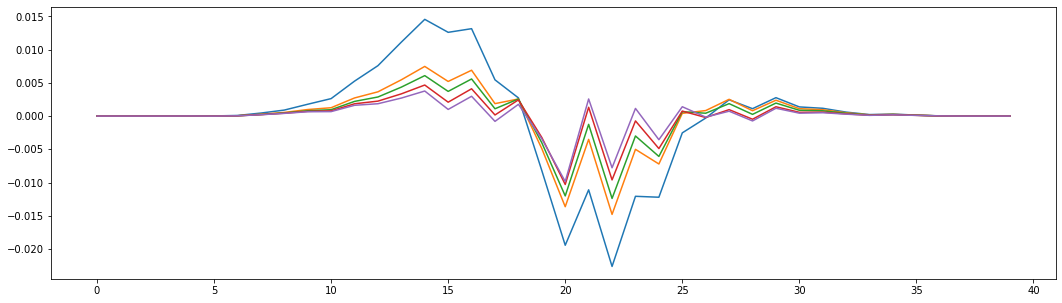

In [49]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

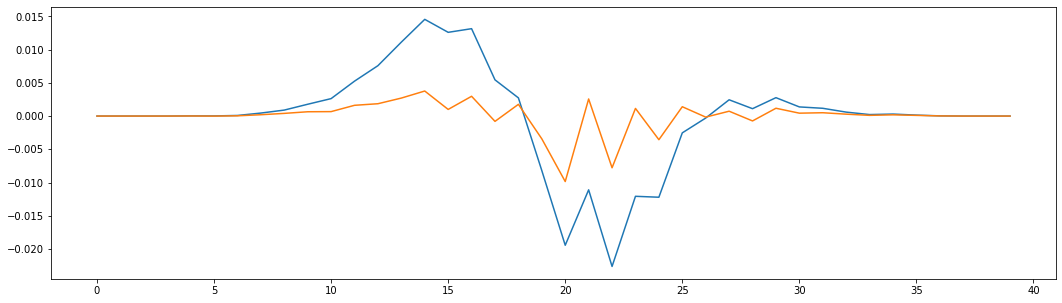

In [50]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

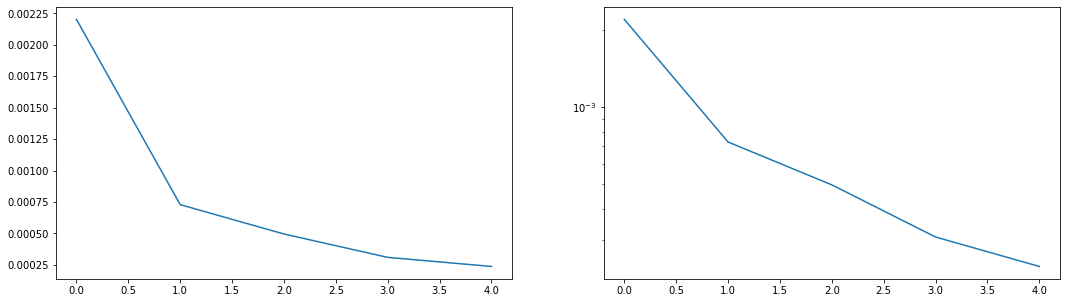

In [51]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [52]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  1.017  rms 0.204      step 2 mean  1.023  rms 0.175
  iter  1 : step 1 mean  0.959  rms 0.064      step 2 mean  0.970  rms 0.050
  iter  2 : step 1 mean  1.001  rms 0.018      step 2 mean  1.002  rms 0.014
  iter  3 : step 1 mean  0.998  rms 0.018      step 2 mean  0.999  rms 0.014
  iter  4 : step 1 mean  0.994  rms 0.009      step 2 mean  0.995  rms 0.008


<function matplotlib.pyplot.show(close=None, block=None)>

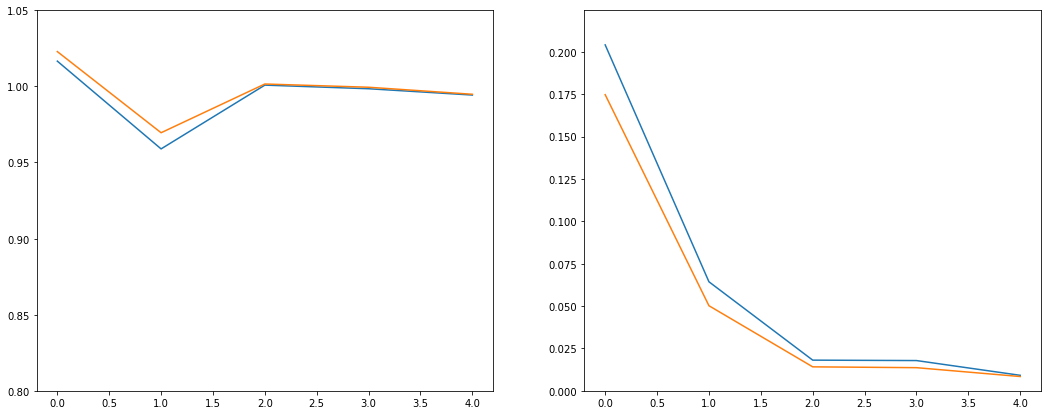

In [53]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

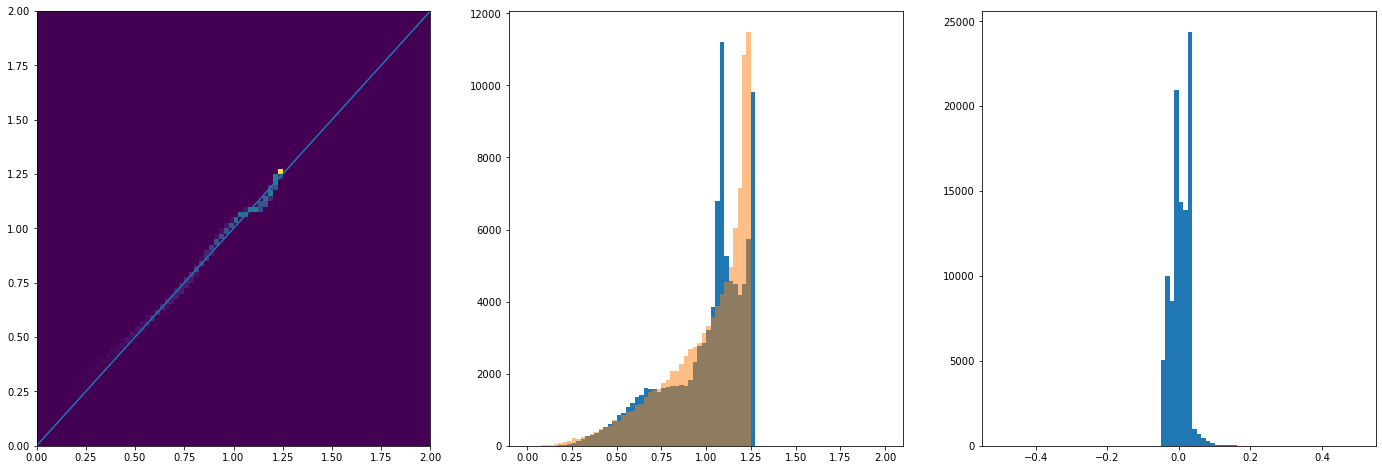

In [54]:
fig,ax = plt.subplots( 1, 3, figsize=(3*8,1*8))
max_weight = 2.0

ax[0].hist2d( calc_weight, final_push_weights, bins=[80,80], range=([0,max_weight],[0,max_weight]))
ax[0].plot([0,max_weight],[0,max_weight])

ax[1].hist( final_push_weights, bins=80, range=[0,max_weight] )
ax[1].hist( calc_weight, bins=80, range=[0,max_weight], alpha=0.5 )

ax[2].hist( final_push_weights-calc_weight, bins=80, range=[-0.5,0.5] )

plt.show

In [55]:

delta_weight_rms = np.sqrt( np.var( np.clip(final_push_weights-calc_weight,-0.5,0.5 ) ) )
print('\n\n Delta weight RMS:  %.5f\n\n' % delta_weight_rms )



 Delta weight RMS:  0.02530




In [56]:

verbose = False



import gc

In [57]:
try:
    os.mkdir( "%s/bootstrap-nn-models" % output_dir )
except :
    print('problem creating bootstrap-nn-models dir')


In [58]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_boot_samples) :
    
    if do_bootstrap :
        print("\n Creating bootstrap sample %3d" % bi )
        boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        
    else :
        print("\n Creating toy sample %3d" % bi )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, resolution )
        
    modeldir = "%s/bootstrap-nn-models/bs-%03d" % (output_dir, bi) 
    
    try:
        os.mkdir( modeldir )
    except :
        print('\n\n *** probelm creating model output directory : %s' % modeldir )
        
    boot_of_return_dict = of.omnifold8a( 
        train_both, boot_true_det_pts, of_niter, model_step1, model_step2, verbose, 
        batch_size_setval, epochs_setval, True, modeldir )



    mc_weight_sf = (1.*len(boot_true_det_pts))/(1.*len(train_both))



    boot_final_push_weights = boot_of_return_dict["final_push_weights"]
    boot_final_push_weights_scaled = boot_final_push_weights
    boot_final_push_weights_scaled = mc_weight_sf * boot_final_push_weights
    
    print("\n\n bootstrap %d final push weights scaled:" % bi)
    print( boot_final_push_weights_scaled )

     
    with open( '%s/bootstrap-weights-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_final_push_weights_scaled )

    with open( '%s/bootstrap-points-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_true_det_pts )
        
        
    del boot_final_push_weights_scaled
    del boot_of_return_dict
    gc.collect()
    
    


 Creating toy sample   0
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-000/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-000/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-000/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0414933  0.86597121 1.15915537 ... 1.10608184 0.97976536 1.05980849]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-000/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-000/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-000/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04217193 0.85758383 1.18249819 ... 1.11004093 0.97862512 1.06083159]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-000/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-000/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-000/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05660027 0.85889097 1.20499589 ... 1.12921924 0.98869415 1.07634304]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-000/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-000/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-000/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06912161 0.85954359 1.24064756 ... 1.15093131 0.99697758 1.09070658]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-000/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-000/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-000/of-step2-iter04-model/assets




 bootstrap 0 final push weights scaled:
[0.10618467 0.08480497 0.12422903 ... 0.11467771 0.09873203 0.10840929]

 Creating toy sample   1
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-001/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-001/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-001/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11942124 0.84935749 1.15533721 ... 1.12379205 1.05093896 1.12157667]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-001/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-001/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-001/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15727103 0.7940315  1.18946498 ... 1.16496597 1.05905534 1.1618434 ]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-001/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-001/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-001/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1586095  0.77570559 1.18256572 ... 1.16124947 1.05250894 1.16296528]
10/10 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-001/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-001/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-001/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18284019 0.76719249 1.19748586 ... 1.17892707 1.06648064 1.18657018]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-001/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-001/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-001/of-step2-iter04-model/assets




 bootstrap 1 final push weights scaled:
[0.1190502  0.07501181 0.11979611 ... 0.11775511 0.10607684 0.1193018 ]

 Creating toy sample   2
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-002/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-002/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-002/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0526613  0.86091077 1.21983922 ... 1.11213386 0.99975544 1.06824362]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-002/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-002/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-002/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04953787 0.84517797 1.22410209 ... 1.10684233 0.9960658  1.06509274]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-002/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-002/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-002/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05615543 0.83955852 1.24215789 ... 1.11674381 1.00104173 1.0723367 ]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-002/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-002/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-002/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05422054 0.8289463  1.24832899 ... 1.11719577 0.9979572  1.07072236]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-002/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-002/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-002/of-step2-iter04-model/assets




 bootstrap 2 final push weights scaled:
[0.10629836 0.0822028  0.12800126 ... 0.11345811 0.10030665 0.10813119]

 Creating toy sample   3
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-003/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-003/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-003/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0774188  0.8813988  1.14858508 ... 1.12157798 0.99050283 1.09773231]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-003/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-003/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-003/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06461748 0.85089361 1.16112426 ... 1.1296381  0.9662146  1.09321849]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-003/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-003/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-003/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07725021 0.83991019 1.1860332  ... 1.15185351 0.96348059 1.11049225]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-003/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-003/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-003/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09219989 0.83478068 1.19425834 ... 1.17132458 0.9662825  1.12687903]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-003/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-003/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-003/of-step2-iter04-model/assets




 bootstrap 3 final push weights scaled:
[0.11024739 0.08259967 0.11980362 ... 0.11878417 0.09626612 0.11407019]

 Creating toy sample   4
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-004/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-004/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-004/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08411014 0.87803191 1.15779269 ... 1.1178174  1.01021421 1.09206986]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-004/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-004/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-004/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09930817 0.87286385 1.1868784  ... 1.14437417 1.01596038 1.10972515]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-004/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-004/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-004/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09984428 0.85517923 1.18937748 ... 1.1572398  1.00705569 1.11411954]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-004/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-004/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-004/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09719746 0.84123633 1.1988134  ... 1.16248784 0.99819867 1.1134669 ]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-004/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-004/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-004/of-step2-iter04-model/assets




 bootstrap 4 final push weights scaled:
[0.11140724 0.08431569 0.12136729 ... 0.11835125 0.10091521 0.11317711]

 Creating toy sample   5
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-005/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-005/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-005/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08621812 0.84095687 1.1780746  ... 1.12689233 1.00345135 1.09982085]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-005/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-005/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-005/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1050615  0.81554718 1.2177316  ... 1.16173789 1.00465832 1.12464723]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-005/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-005/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-005/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10712458 0.79690728 1.23576007 ... 1.1771683  0.99567059 1.13082376]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-005/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-005/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-005/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11083175 0.78416534 1.24886763 ... 1.18992985 0.98956946 1.13792757]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-005/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-005/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-005/of-step2-iter04-model/assets




 bootstrap 5 final push weights scaled:
[0.11098892 0.07710359 0.12505431 ... 0.11922718 0.09810827 0.11385536]

 Creating toy sample   6
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-006/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-006/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-006/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05082846 0.8519882  1.16913056 ... 1.10516238 1.00355375 1.06495726]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-006/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-006/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-006/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06322177 0.8365481  1.17890216 ... 1.12644062 1.00273384 1.079706  ]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-006/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-006/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-006/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07612248 0.81840705 1.19756605 ... 1.14957113 1.00233328 1.09621563]
10/10 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-006/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-006/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-006/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08019267 0.80364737 1.20216039 ... 1.16071792 0.9964355  1.10223027]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-006/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-006/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-006/of-step2-iter04-model/assets




 bootstrap 6 final push weights scaled:
[0.10851731 0.07912502 0.119909   ... 0.11719673 0.09927741 0.11095341]

 Creating toy sample   7
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-007/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-007/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-007/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0256325  0.87111735 1.16431582 ... 1.10041606 0.96467888 1.046121  ]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-007/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-007/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-007/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03932825 0.86012357 1.20109237 ... 1.13450012 0.95990811 1.06666604]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-007/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-007/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-007/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04126341 0.84415071 1.22650148 ... 1.1572112  0.94605287 1.07517154]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-007/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-007/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-007/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04358498 0.83327762 1.23589594 ... 1.17158162 0.93547646 1.08291188]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-007/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-007/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-007/of-step2-iter04-model/assets




 bootstrap 7 final push weights scaled:
[0.10543857 0.08369131 0.12367758 ... 0.11855031 0.09411226 0.10952887]

 Creating toy sample   8
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-008/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-008/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-008/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04792798 0.89455473 1.17705619 ... 1.10609925 0.9870277  1.06783092]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-008/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-008/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-008/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05142844 0.88597913 1.19888502 ... 1.11794003 0.98327067 1.07462684]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-008/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-008/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-008/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04870605 0.87283056 1.21369421 ... 1.12452018 0.97332603 1.07545709]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-008/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-008/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-008/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05552677 0.87203182 1.23746587 ... 1.14002089 0.97564175 1.08404525]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-008/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-008/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-008/of-step2-iter04-model/assets




 bootstrap 8 final push weights scaled:
[0.10403887 0.08578469 0.12261859 ... 0.11269398 0.09602649 0.10695027]

 Creating toy sample   9
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-009/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-009/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-009/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05094719 0.83131182 1.16717315 ... 1.09559476 0.98348314 1.06822526]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-009/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-009/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-009/of-step2-iter01-model/assets


 weights_push at the beginning
[1.059949   0.81930481 1.21239324 ... 1.11920463 0.98315914 1.08229545]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-009/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-009/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-009/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07985041 0.82301602 1.24738027 ... 1.14667599 0.99601722 1.10421164]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-009/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-009/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-009/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06798283 0.80327979 1.24638012 ... 1.1394789  0.97922045 1.09385178]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-009/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-009/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-009/of-step2-iter04-model/assets




 bootstrap 9 final push weights scaled:
[0.1082038  0.08023756 0.1276778  ... 0.11617417 0.09867225 0.11101023]

 Creating toy sample  10
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-010/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-010/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-010/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06293356 0.8300494  1.16847789 ... 1.11041486 0.97487509 1.07638705]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-010/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-010/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-010/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07814288 0.80925939 1.20736207 ... 1.13659588 0.97510985 1.09564051]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-010/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-010/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-010/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09752375 0.80233584 1.23163307 ... 1.17264076 0.98003421 1.11949182]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-010/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-010/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-010/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08907469 0.78312943 1.22642947 ... 1.17493135 0.96319235 1.11418543]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-010/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-010/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-010/of-step2-iter04-model/assets




 bootstrap 10 final push weights scaled:
[0.10808272 0.07668704 0.12065112 ... 0.11718311 0.09488458 0.11081462]

 Creating toy sample  11
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-011/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-011/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-011/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06855786 0.85528702 1.15669811 ... 1.12845027 0.96732807 1.08860254]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-011/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-011/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-011/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0970913  0.83632927 1.1936473  ... 1.18141808 0.96554214 1.12801572]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-011/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-011/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-011/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1170826  0.82852275 1.21244403 ... 1.21628654 0.9613365  1.15668135]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-011/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-011/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-011/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10873885 0.80866473 1.19686306 ... 1.21353835 0.94061523 1.15465958]
10/10 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-011/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-011/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-011/of-step2-iter04-model/assets




 bootstrap 11 final push weights scaled:
[0.11147855 0.08014401 0.11919784 ... 0.12303316 0.09342425 0.11664508]

 Creating toy sample  12
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-012/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-012/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-012/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06656682 0.93010396 1.15706944 ... 1.10281909 0.9887135  1.07754362]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-012/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-012/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-012/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05741883 0.89897224 1.15873692 ... 1.09913257 0.97126123 1.07040682]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-012/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-012/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-012/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07303959 0.89349263 1.19330506 ... 1.12475631 0.97614428 1.08935974]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-012/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-012/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-012/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07807053 0.88308177 1.21070076 ... 1.13649661 0.97406395 1.09691419]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-012/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-012/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-012/of-step2-iter04-model/assets




 bootstrap 12 final push weights scaled:
[0.10780613 0.08733422 0.12172603 ... 0.11387304 0.0970573  0.10979005]

 Creating toy sample  13
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-013/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-013/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-013/of-step2-iter00-model/assets


 weights_push at the beginning
[1.068349   0.87015402 1.16767704 ... 1.10958695 1.01673639 1.08071458]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-013/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-013/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-013/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07007711 0.84856912 1.18142284 ... 1.11952106 1.01174416 1.08479724]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-013/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-013/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-013/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0763198  0.8317501  1.19671319 ... 1.13361148 1.01088669 1.09336391]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-013/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-013/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-013/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0895742  0.81847211 1.21388623 ... 1.15374933 1.0180724  1.10877065]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-013/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-013/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-013/of-step2-iter04-model/assets




 bootstrap 13 final push weights scaled:
[0.10882868 0.08085767 0.12099802 ... 0.11566195 0.1013996  0.11088893]

 Creating toy sample  14
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-014/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-014/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-014/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06750989 0.87239784 1.17241728 ... 1.11134124 0.98434824 1.0868243 ]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-014/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-014/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-014/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07656665 0.84882671 1.22501347 ... 1.14181466 0.98168478 1.10041224]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-014/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-014/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-014/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07373253 0.82705347 1.23199706 ... 1.14443378 0.97278507 1.09985414]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-014/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-014/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-014/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08753964 0.82582008 1.25503966 ... 1.16325882 0.98180332 1.11508408]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-014/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-014/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-014/of-step2-iter04-model/assets




 bootstrap 14 final push weights scaled:
[0.10758382 0.08056026 0.12479578 ... 0.11532264 0.09663764 0.11037037]

 Creating toy sample  15
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-015/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-015/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-015/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06932199 0.86303681 1.1624552  ... 1.10865951 0.99596643 1.08403099]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-015/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-015/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-015/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08290769 0.85694712 1.20488022 ... 1.13152283 1.00156401 1.10054614]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-015/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-015/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-015/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08603651 0.8446695  1.22786838 ... 1.14226099 0.99810822 1.10633999]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-015/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-015/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-015/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08652291 0.82930187 1.25509616 ... 1.15244637 0.99206973 1.10930953]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-015/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-015/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-015/of-step2-iter04-model/assets




 bootstrap 15 final push weights scaled:
[0.10806573 0.08133467 0.12643205 ... 0.11522183 0.09822612 0.11050562]

 Creating toy sample  16
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-016/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-016/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-016/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05967772 0.86672676 1.15023077 ... 1.09579551 0.99730766 1.07339883]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-016/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-016/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-016/of-step2-iter01-model/assets


 weights_push at the beginning
[1.069894   0.86497581 1.19309391 ... 1.11607475 1.0005312  1.08640152]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-016/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-016/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-016/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0667003  0.85524214 1.2089883  ... 1.11848715 0.99359174 1.08462446]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-016/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-016/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-016/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0596682  0.84290376 1.22546844 ... 1.11807235 0.98391333 1.07929011]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-016/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-016/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-016/of-step2-iter04-model/assets




 bootstrap 16 final push weights scaled:
[0.10607177 0.08348319 0.12472065 ... 0.11251296 0.09819808 0.10819116]

 Creating toy sample  17
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-017/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-017/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-017/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04976201 0.90175456 1.17326486 ... 1.10100758 1.00944448 1.06514657]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-017/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-017/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-017/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06091173 0.88196996 1.22285297 ... 1.12478607 1.00555548 1.08035999]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-017/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-017/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-017/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06285457 0.86101281 1.25079564 ... 1.13506838 0.9962417  1.08446772]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-017/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-017/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-017/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05168464 0.83697995 1.24676731 ... 1.12872866 0.97975485 1.074579  ]
10/10 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-017/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-017/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-017/of-step2-iter04-model/assets




 bootstrap 17 final push weights scaled:
[0.10535219 0.08264364 0.12527905 ... 0.11348104 0.09778841 0.10777924]

 Creating toy sample  18
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-018/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-018/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-018/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05664337 0.88436228 1.17746449 ... 1.10961163 1.012761   1.07059073]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-018/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-018/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-018/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05955888 0.86503154 1.20102484 ... 1.12067348 1.00500424 1.07602702]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-018/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-018/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-018/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06119433 0.85155827 1.20808858 ... 1.12798298 1.00098721 1.07897536]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-018/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-018/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-018/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07587299 0.84893536 1.23296609 ... 1.14926129 1.01091939 1.0952594 ]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-018/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-018/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-018/of-step2-iter04-model/assets




 bootstrap 18 final push weights scaled:
[0.10754632 0.08392225 0.12320414 ... 0.11518546 0.10076256 0.10958573]

 Creating toy sample  19
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-019/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-019/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-019/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05357814 0.90140569 1.16391921 ... 1.1027925  1.00493169 1.06663585]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-019/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-019/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-019/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06101118 0.88648468 1.19636256 ... 1.12002547 1.0046658  1.07637296]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-019/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-019/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-019/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06133244 0.87104942 1.20828838 ... 1.12878529 0.9991376  1.07871494]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-019/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-019/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-019/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06636012 0.86136977 1.23346586 ... 1.14321178 0.99786013 1.08591897]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-019/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-019/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-019/of-step2-iter04-model/assets




 bootstrap 19 final push weights scaled:
[0.10680401 0.08502941 0.12521388 ... 0.11533    0.0993985  0.10895647]

 Creating toy sample  20
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-020/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-020/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-020/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0519172  0.88123178 1.13755774 ... 1.08360851 1.01577592 1.06032419]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-020/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-020/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-020/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06162854 0.86699932 1.18545918 ... 1.10554702 1.01640873 1.07326368]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-020/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-020/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-020/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06159412 0.85172147 1.20262547 ... 1.11296003 1.01033805 1.07526151]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-020/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-020/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-020/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07839008 0.85226447 1.22990064 ... 1.13487597 1.02081828 1.09350567]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-020/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-020/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-020/of-step2-iter04-model/assets




 bootstrap 20 final push weights scaled:
[0.10725963 0.0837799  0.1228877  ... 0.1131678  0.10115061 0.10883677]

 Creating toy sample  21
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-021/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-021/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-021/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04590559 0.8783288  1.14258337 ... 1.07848895 1.004861   1.05463219]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-021/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-021/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-021/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06620938 0.873257   1.20049526 ... 1.11303962 1.01355802 1.07895247]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-021/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-021/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1b/bootstrap-nn-models/bs-021/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05729164 0.85267917 1.20585059 ... 1.1099545  0.99936827 1.07155894]


KeyboardInterrupt: 

In [59]:
print('\n\n Done.\n\n')



 Done.


